Utility notebook to skim candidates

# Import

In [1]:
import sys, os, pickle, time
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
import itertools
import json
from IPython.display import IFrame, Image, display
from multiprocessing import Pool

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.interpolate import interp1d
from array import array

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist
from cebefo_style import Set_2D_colz_graphics
from gridVarQ2Plot import col_dic, plot_gridVarQ2
from progressBar import ProgressBar
from categoriesDef import categories
from B02DstMu_selection import candidate_selection, trigger_selection, candidateSelection_stringList, candidateSelection_nameList

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1


CMS_lumi.extraText = "     Simulation Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


# Create histograms file

In [3]:
MCloc = '../data/cmsMC_private/BPH_Tag-'
file_loc = {
'mu'    : MCloc+'B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
'mu_PU0': MCloc+'B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU0_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
# 'mu_HQETPU0': MCloc+'B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_HQET2_central_PU0_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
# 'tau'   : MCloc+'B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
# 'Hc'    : MCloc+'B0_DmstHc-pD0bar-kp-Hc2mu_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
# 'Dstst' : MCloc+'Bp_MuNuDstst_DmstPi_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/out_CAND_*.root',
# 'data' : '../data/cmsRD/ParkingBPH1/Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200210_CAND.root'
}

In [4]:
def makeSelection(inputs):
    tag, filepath, leafs_names, cat, idxInt, skipCut, serial = inputs
    N_accepted_cand = []
    N_accepted_tot = 0
    
    tree = rt.TChain('outA/Tevts')
    lastIdxDisc = -1
    for fn in glob(filepath):
        tree.Add(fn)
        if tree.GetEntries() + lastIdxDisc < idxInt[0]:
            lastIdxDisc += tree.GetEntries()
            tree = rt.TChain('outA/Tevts')
        elif tree.GetEntries() + lastIdxDisc > idxInt[1]:
            break
    
    nDiscEvts = lastIdxDisc + 1
            
        
    if serial:
        pb = ProgressBar(maxEntry=idxInt[1]+1)
    else:
        perc = int((idxInt[1]-idxInt[0])*0.3)
    
    output = np.zeros((int(1.5*(idxInt[1]-idxInt[0]+1)), len(leafs_names)))
    for i_ev, ev in enumerate(tree):
        i_ev += nDiscEvts
        if i_ev < idxInt[0]:
            continue
        if i_ev > idxInt[1]:
            break
            
        if serial:
            pb.show(i_ev-idxInt[0])
        elif (i_ev-idxInt[0]) % perc == 0:
            print tag, ': {:.0f}%'.format(100*(i_ev+1-idxInt[0])/(idxInt[1]-idxInt[0]))
        N_acc = 0

        for j in range(ev.pval_piK.size()):
            idxTrg = int(ev.mu_trgMu_idx[j])
            if not skipCut == 'all':
                if not candidate_selection(j, ev, skipCut):
                    continue

                if not trigger_selection(idxTrg, ev, cat): 
                    continue

            N_acc += 1
            
            idx_st = 0
            for jjj in range(j):
                idx_st += int(ev.nTksAdd[jjj])

            N_lowMassAddTks = 0
            idx_stop = int(idx_st + ev.nTksAdd[j])
            for jj in range(idx_st, idx_stop):
                if ev.tksAdd_massVis[jj] < 5.28:
                    N_lowMassAddTks += 1
            

            aux = (ev.q2_D0pismu[j], ev.Est_mu_D0pismu[j], ev.M2_miss_D0pismu[j],
                   ev.trgMu_pt[idxTrg], ev.trgMu_eta[idxTrg], ev.trgMu_phi[idxTrg], ev.trgMu_sigdxy[idxTrg],
                   ev.B_D0pismu_pt[j], ev.B_D0pismu_eta[j], ev.B_D0pismu_phi[j],
                   ev.Dst_refitD0pismu_pt[j], ev.Dst_refitD0pismu_eta[j], ev.Dst_refitD0pismu_phi[j],
                   ev.D0_refitD0pismu_pt[j], ev.D0_refitD0pismu_eta[j], ev.D0_refitD0pismu_phi[j],
                   ev.pi_pt[j], ev.pi_eta[j], ev.pi_phi[j], ev.sigdxy_pi_PV[j],
                   ev.K_pt[j], ev.K_eta[j], ev.K_phi[j], ev.sigdxy_K_PV[j],
                   ev.pval_piK[j], ev.sigdxy_vtxD0_PV[j],
                   ev.pis_pt[j], ev.pis_eta[j], ev.pis_phi[j], ev.sigdxy_pis_PV[j],
                   ev.pval_D0pis[j],
                   ev.mass_piK[j], ev.mass_D0pis[j], ev.mass_D0pismu[j],
                   ev.pval_D0pismu[j], ev.cos_D0pismu_PV[j],
                   N_lowMassAddTks,
                   trigger_selection(idxTrg, ev, categories['low']),
                   trigger_selection(idxTrg, ev, categories['mid']),
                   trigger_selection(idxTrg, ev, categories['high']),
                   ev.N_vertexes
                  )
            if not 'data' in n:
                aux += (ev.MC_q2, ev.MC_Est_mu, ev.MC_M2_miss,
                        ev.MC_B_pt, ev.MC_B_eta, ev.MC_B_phi,
                        ev.MC_Dst_pt, ev.MC_Dst_eta, ev.MC_Dst_phi,
                        ev.MC_mu_pt, ev.MC_mu_eta, ev.MC_mu_phi, ev.MC_mu_IP,
                        ev.MC_idxCand == j
                       )
            if n in ['tau', 'mu']:
                aux += (ev.wh_CLNCentral,
                        ev.wh_CLNR0Down, ev.wh_CLNR0Up,
                        ev.wh_CLNR1Down, ev.wh_CLNR1Up,
                        ev.wh_CLNR2Down, ev.wh_CLNR2Up,
                        ev.wh_CLNRhoSqDown, ev.wh_CLNRhoSqUp,
                       )
        
            output[N_accepted_tot] = aux
            N_accepted_tot += 1

        if N_acc > 0:
            N_accepted_cand.append(N_acc)

    output = output[:N_accepted_tot]
    if not serial:
        print tag, ': done'
    return [output, N_accepted_cand]

In [5]:
def create_dSet(n, filepath, cat, skipCut=None, maxEntries=1e15):  
    if skipCut=='all' and cat is None:
        catName = 'All'
    else:
        catName = cat.name
    print n, catName
    if 'data' in n:
        fskimmed_name = filepath.replace('CAND.root', 'skim{}.root'.format(catName))
    else:
        d = os.path.dirname(filepath) + '/skimmed/'
        if not os.path.isdir(d):
            os.makedirs(d)
        fskimmed_name = d + catName 
        if not skipCut is None:
            fskimmed_name += '_skip'+str(skipCut)
        fskimmed_name += '.root'
    logfile = fskimmed_name.replace('.root', '.log')
    if os.path.isfile(fskimmed_name) and not n in recreate:
        print 'Already present'
    else:
        tree = rt.TChain('outA/Tevts')
        for fn in glob(filepath):
            tree.Add(fn)
        N_cand_in = min(maxEntries, tree.GetEntries())
        print n, ': Total number of candidate events =', N_cand_in
            
        leafs_names = ['q2', 'Est_mu', 'M2_miss',
                       'mu_pt', 'mu_eta', 'mu_phi', 'mu_sigdxy',
                       'B_pt', 'B_eta', 'B_phi',
                       'Dst_pt', 'Dst_eta', 'Dst_phi',
                       'D0_pt', 'D0_eta', 'D0_phi',
                       'pi_pt', 'pi_eta', 'pi_phi', 'pi_IP',
                       'K_pt', 'K_eta', 'K_phi', 'K_IP',
                       'pval_piK', 'sigdxy_vtxD0_PV',
                       'pis_pt', 'pis_eta', 'pis_phi', 'pis_IP',
                       'pval_D0pis',
                       'mass_piK', 'mass_D0pis', 'mass_D0pismu',
                       'pval_D0pismu', 'cos_D0pismu_PV',
                       'N_lowMassAddTks',
                       'cat_low', 'cat_mid', 'cat_high',
                       'N_vtx'
                      ]
        if not 'data' in n:
            leafs_names += ['MC_q2', 'MC_Est_mu', 'MC_M2_miss',
                            'MC_B_pt', 'MC_B_eta', 'MC_B_phi',
                            'MC_Dst_pt', 'MC_Dst_eta', 'MC_Dst_phi',
                            'MC_mu_pt', 'MC_mu_eta', 'MC_mu_phi', 'MC_mu_IP',
                            'MC_idxMatch'
                           ]
        if n in ['tau', 'mu']:
            leafs_names += ['wh_CLNCentral', 
                            'wh_CLNR0Down', 'wh_CLNR0Up', 
                            'wh_CLNR1Down', 'wh_CLNR1Up', 
                            'wh_CLNR2Down', 'wh_CLNR2Up', 
                            'wh_CLNRhoSqDown', 'wh_CLNRhoSqUp']
            
        if N_cand_in < 60000:
            output, N_accepted_cand = makeSelection(['', filepath, leafs_names, cat, 
                                                     [0, N_cand_in-1], skipCut, True])
        else:
            pdiv = list(np.arange(0, N_cand_in, 30000))
            if not pdiv[-1] == N_cand_in: 
                pdiv.append(N_cand_in)
            print 'Will be divided into ' + str(len(pdiv)-1) + ' jobs'
            inputs = []
            for i in range(1, len(pdiv)):
                corr = 0
                if i == 1:
                    corr = -1
                inputs.append([str(i), filepath, leafs_names, cat, [pdiv[i-1]+1+corr, pdiv[i]], skipCut, False])
            print ' '
            
            start = time.time()
            p = Pool(min(20,len(inputs)))
            outputs = p.map(makeSelection, inputs)
            output = np.concatenate(tuple([o[0] for o in outputs]))
            N_accepted_cand = []
            for o in outputs: N_accepted_cand += o[1]
            print 'Total time: {:.1f} min'.format((time.time()-start)/60.)
                
        
        dset = pd.DataFrame(output, columns=leafs_names)
        if not os.path.isdir(os.path.dirname(fskimmed_name)):
            os.makedirs(os.path.dirname(fskimmed_name))
        rtnp.array2root(dset.to_records(), fskimmed_name, treename='Tevts', mode='RECREATE')
        
        with open(logfile, 'w') as f:
            ln = 'Number of candidates per events\n{'
            ln += ', '.join(['{}:{}'.format(i, N_accepted_cand.count(i)) for i in range(1, np.max(N_accepted_cand)+1)])
            ln += '}\n'
            f.write(ln)
            f.write('N_analyzed: '+str(N_cand_in)+'\n')
            f.write('N_accepted: '+str(dset.shape[0])+'\n')
            e = getEff(dset.shape[0], N_cand_in)
            f.write('Eff: {:.3f} +/- {:.3f} %'.format(1e2*e[0], 1e2*e[1])+'\n')
         
    os.system('echo '+logfile+';cat '+logfile + ';echo ')

In [6]:
from categoriesDef import categories

recreate = [] #file_loc.keys()

for n, fp in file_loc.iteritems():
#     create_dSet(n, fp, categories[cn], None)
    create_dSet(n, fp, None, 'all', maxEntries=1e9)
            
# skipping_list = [None] + list(range(1,22))
# for sk in skipping_list:
#     for cn in ['low']: #, 'mid', 'high']:
#         for n, fp in file_loc.iteritems():
#             create_dSet(n, fp, categories[cn], sk)

mu All
Already present
mu_PU0 All
Already present
../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU20_10-2-3/ntuples_B2DstMu/skimmed/All_skipall.log
Number of candidates per events
{1:856468, 2:4337, 3:20, 4:9}
N_analyzed: 860834
N_accepted: 865238
Eff: 100.512 +/- nan %

../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_ISGW2_PU0_10-2-3/ntuples_B2DstMu/skimmed/All_skipall.log
Number of candidates per events
{1:261794, 2:1208, 3:5}
N_analyzed: 263007
N_accepted: 264225
Eff: 100.463 +/- nan %



# Analyze selection efficiencies

In [7]:
def getTree(n, filepath, cat, skipCut=None, maxEntries=1e15):  
    if skipCut=='all' and cat is None:
        catName = 'All'
    else:
        catName = cat.name
    print n, catName, skipCut
    if 'data' in n:
        fskimmed_name = filepath.replace('CAND.root', 'skim{}.root'.format(catName))
    else:
        d = os.path.dirname(filepath) + '/skimmed/'
        fskimmed_name = d + catName 
        if not skipCut is None:
            fskimmed_name += '_skip'+str(skipCut)
        fskimmed_name += '.root'
    if os.path.isfile(fskimmed_name):
        t = rt.TChain('Tevts')
        t.Add(fskimmed_name)
        return t
    else: return None

## Get efficiency per cut

In [8]:
T = {}
for n, fp in file_loc.iteritems():
    aux = getTree(n, fp, None, 'all', maxEntries=1e9)
    if not aux is None:
        T[n] = aux

mu All all
mu_PU0 All all


mu
[####################]  100% - Tot. time: 2.1 s
mu_PU0
[####################]  100% - Tot. time: 0.7 s


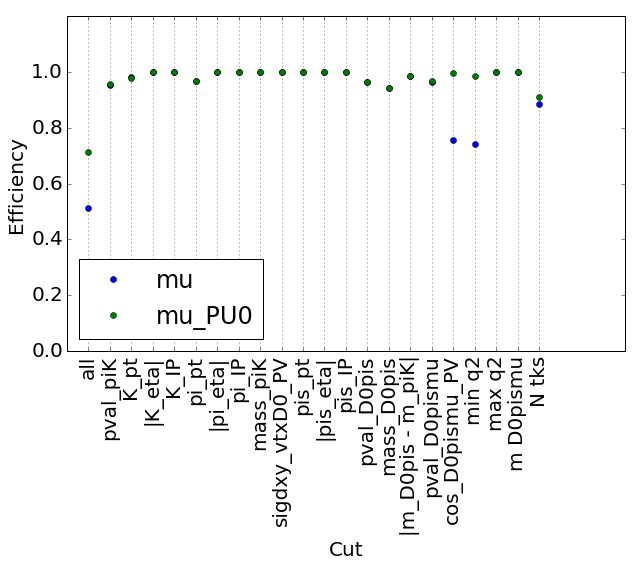

In [25]:
allCuts = ' && '.join(candidateSelection_stringList)
eff = {}
for n, t in T.iteritems():
    print n
    eff[n] = np.zeros(len(candidateSelection_stringList)+1)
    Ntot = float(t.GetEntries())
    Nsel = t.GetEntries(allCuts)
    eff[n][0] = Nsel/Ntot
    pb = ProgressBar(maxEntry=len(candidateSelection_stringList))
    for ic, c in enumerate(candidateSelection_stringList):
        pb.show(ic)
        eff[n][ic+1] = t.GetEntries(c)/Ntot 

for n in T.keys():
    plt.plot(eff[n], 'o', label=n)

plt.rcParams.update({'font.size': 20})
plt.xlabel('Cut')
plt.ylabel('Efficiency')
plt.legend(loc='best', numpoints=1)
plt.xticks(range(len(candidateSelection_nameList)+1), ['all']+candidateSelection_nameList, rotation=90)
plt.ylim(0,1.2)
plt.xlim(-1,plt.xlim()[1])
plt.grid(axis='x')
plt.gcf().set_size_inches(10, 6)

mu
mu_PU0


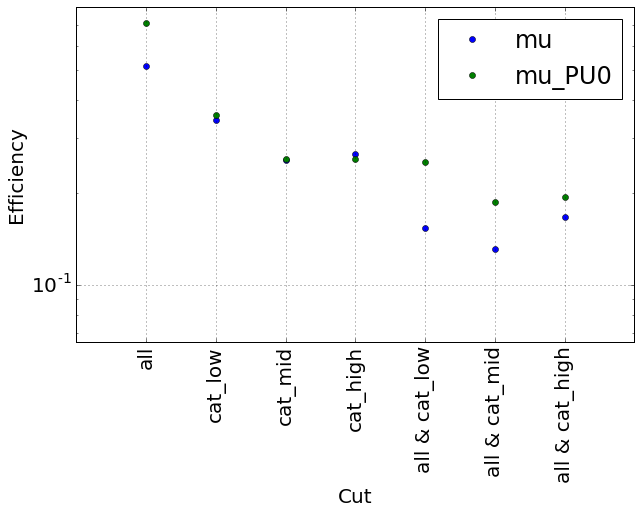

In [32]:
allCuts = ' && '.join(candidateSelection_stringList)
cat = ['cat_low', 'cat_mid', 'cat_high']
eff = {}
for n, t in T.iteritems():
    print n
    eff[n] = np.zeros(2*len(cat)+1)
    Ntot = float(t.GetEntries())
    Nsel = t.GetEntries(allCuts)
    eff[n][0] = Nsel/Ntot
    for ic, c in enumerate(cat):
        eff[n][ic+1] = t.GetEntries(c)/Ntot 
    for ic, c in enumerate(cat):
        eff[n][ic+1+len(cat)] = t.GetEntries(c + ' && ' + allCuts)/Ntot 

for n in T.keys():
    plt.plot(eff[n], 'o', label=n)

plt.rcParams.update({'font.size': 20})
plt.xlabel('Cut')
plt.ylabel('Efficiency')
plt.legend(loc='best', numpoints=1)
plt.xticks(range(2*len(cat)+1), ['all']+cat+['all & '+c for c in cat], rotation=90)
plt.ylim(0.5*np.min([np.min(e) for e in eff.values()]), plt.ylim()[1])
plt.xlim(-1,plt.xlim()[1]+1)
plt.yscale('log')
plt.grid()
plt.gcf().set_size_inches(10, 6)